In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import nibabel as nib
from ipywidgets import interact
from torch.utils.data import Dataset, DataLoader
import os
from collections import Counter
from pathlib import Path
from torch.utils.data import random_split
import math
import torch.nn.functional as F
from collections import OrderedDict
import pytorch_lightning as pl

In [3]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: page0526 (iai-uet-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
im = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii')
data = im.get_fdata()
data.shape, im.affine, im.header

((130, 130, 130),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 <nibabel.nifti1.Nifti1Header at 0x78a4c5a9a090>)

In [5]:
def show_slice(slice_index):
    plt.imshow(data[:, :, slice_index], cmap='gray')
    plt.title(f"Axial Slice {slice_index}")
    plt.axis('off')
    plt.show()

interact(show_slice, slice_index=(0, data.shape[2] - 1));

interactive(children=(IntSlider(value=64, description='slice_index', max=129), Output()), _dom_classes=('widge…

In [6]:
# read label csv
data_dir = '/kaggle/input/mri-dataset/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])

In [7]:
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [8]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]

In [9]:
label_ls.head(), len(label_ls)

(   subject_age subject_dx subject_sex          subject_id   dataset_name
 19        44.2    control           m  sub-BrainAge000019  ABIDE/Caltech
 20        39.3    control           m  sub-BrainAge000020  ABIDE/Caltech
 21        42.5    control           m  sub-BrainAge000021  ABIDE/Caltech
 22        19.7    control           m  sub-BrainAge000022  ABIDE/Caltech
 23          20    control           f  sub-BrainAge000023  ABIDE/Caltech,
 8764)

In [10]:
sexes = label_ls[['subject_sex','subject_id']]
sexes.head()

,subject_sex,subject_id
19,m,sub-BrainAge000019
20,m,sub-BrainAge000020
21,m,sub-BrainAge000021
22,m,sub-BrainAge000022
23,f,sub-BrainAge000023


In [11]:
sexes_dict = sexes.set_index('subject_id')['subject_sex'].to_dict()
len(sexes_dict)

8764

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        # Gather valid image paths
        self.im_filenames = [
            path for path in sorted(self.im_dir.glob("*/*/*/*.nii"))
            if self._is_valid(path)
        ]

    def _is_valid(self, path):
        subject_id = self.extract_subject_id(path)
        if subject_id not in self.label_ls:
            return False
        try:
            nib.load(path).get_fdata()  # just try loading (don't call get_fdata() yet)
            return True
        except Exception:
            return False

    def extract_subject_id(self, im_path):
        for part in Path(im_path).parts:
            if part.startswith("sub-BrainAge"):
                return part
        return None

    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        im = nib.load(im_path).get_fdata()

        # Normalize
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)  # avoid divide-by-zero
        im = im.astype(np.float32)

        subject_id = self.extract_subject_id(im_path)
        sex = self.label_ls.get(subject_id)
        if sex == 'm':
            label = 0
        elif sex == 'f':
            label = 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")

        if self.transform:
            im = self.transform(im)

        # add channel dim
        return torch.as_tensor(im), torch.tensor(label, dtype=torch.long)


In [13]:
dataset = MRIDataset(data_dir, sexes_dict)
# check length
len(dataset)

4948

In [14]:
def visualize_interact(dataset, seed=0):
    # Select one random image
    np.random.seed(seed)
    idx = np.random.choice(len(dataset))
    im, label = dataset[idx]
    im = im.numpy()

    # Interactive slider
    def show_slice(slice_index):
        plt.imshow(im[:, :, slice_index], cmap='gray')
        plt.title(f'Axial Slice {slice_index} | Label: {label}')
        plt.axis('off')
        plt.show()

    interact(show_slice, slice_index=(0, im.shape[2] - 1))

In [15]:
visualize_interact(dataset, seed=123), visualize_interact(dataset, seed=1024)

interactive(children=(IntSlider(value=64, description='slice_index', max=129), Output()), _dom_classes=('widge…

interactive(children=(IntSlider(value=64, description='slice_index', max=129), Output()), _dom_classes=('widge…

(None, None)

In [16]:
def distribution(dataset):
    labels = [int(dataset[i][1]) for i in range(len(dataset))]
    label_counts = Counter(labels)
    plt.figure(figsize=(8, 5))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

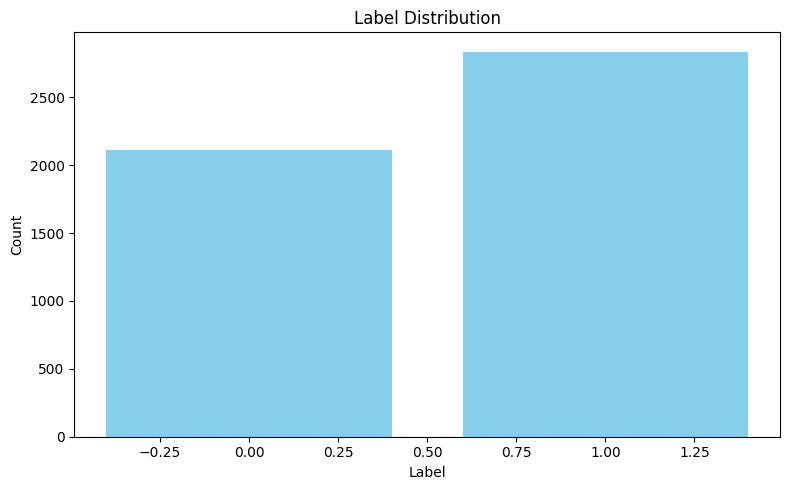

In [17]:
distribution(dataset)

In [18]:
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

trainset, valset, testset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size = 16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size = 16, shuffle=False, num_workers=2)
valloader = DataLoader(valset, batch_size = 16, shuffle=False, num_workers=2)

In [19]:
class _DenseLayer(nn.Sequential):

    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate,
                 drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)


class _Transition(nn.Sequential):

    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    
    """
    Densenet-BC model class
    
    Args:
        growth_rate (int) - how many filters to add each layer (k in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=1):

        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out,
                                    output_size=(1, 1,
                                                 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out
 

In [20]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))

/tmp/ipykernel_31/2273666224.py:127: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [21]:
from torchinfo import summary

summary(model, input_size=(8, 1, 130, 130, 130))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [8, 1]                    --
├─Sequential: 1-1                        [8, 364, 8, 4, 4]         --
│    └─Conv3d: 2-1                       [8, 32, 130, 65, 65]      10,976
│    └─BatchNorm3d: 2-2                  [8, 32, 130, 65, 65]      64
│    └─ReLU: 2-3                         [8, 32, 130, 65, 65]      --
│    └─MaxPool3d: 2-4                    [8, 32, 65, 33, 33]       --
│    └─_DenseBlock: 2-5                  [8, 96, 65, 33, 33]       --
│    │    └─_DenseLayer: 3-1             [8, 48, 65, 33, 33]       29,888
│    │    └─_DenseLayer: 3-2             [8, 64, 65, 33, 33]       30,944
│    │    └─_DenseLayer: 3-3             [8, 80, 65, 33, 33]       32,000
│    │    └─_DenseLayer: 3-4             [8, 96, 65, 33, 33]       33,056
│    └─_Transition: 2-6                  [8, 48, 32, 16, 16]       --
│    │    └─BatchNorm3d: 3-5             [8, 96, 65, 33, 33]     

In [22]:
from torchmetrics import MeanMetric

class DenseNetModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, weight_decay = 1e-2):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        # how confidence model is in it prediction
        # tức model có thể rất tự tin trong quyết định nhưng thực tế lại sai
        # BCE = y*log(y_pred) + (1 - y)*log(1 - y_pred)
        self.criterion = nn.BCEWithLogitsLoss()
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # x.shape  = (batch_size, in_channel, height, width, depth), y.shape = (batch_size)
        logits = self(x.unsqueeze(1))
        
        loss = self.criterion(logits, y.float().unsqueeze(1))
        self.train_loss(loss)
        acc = ((torch.sigmoid(logits) > 0.5).float() == y.unsqueeze(1)).float().mean()
        
        self.log('train_loss', self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x.unsqueeze(1))
        
        loss = self.criterion(logits, y.float().unsqueeze(1))
        self.val_loss(loss)
        acc = ((torch.sigmoid(logits) > 0.5).float() == y.unsqueeze(1)).float().mean()
        
        self.log('val_loss', self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x.unsqueeze(1))
        
        loss = self.criterion(logits, y.float().unsqueeze(1))
        self.test_loss(loss)
        acc = ((torch.sigmoid(logits) > 0.5).float() == y.unsqueeze(1)).float().mean()
        
        self.log('test_loss', self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer =  torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay = self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val_loss",
           },
        }

In [23]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


wandb_logger = WandbLogger(project="sex-classification", log_model=True)
module = DenseNetModule(model, lr=1e-4)

# Checkpoint callback
checkpoint_cb = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)

# Trainer
trainer = Trainer(
    max_epochs=10,
    logger=wandb_logger,
    callbacks=[checkpoint_cb, early_stopping],
    accelerator="auto",
    devices="auto",
    log_every_n_steps=10,
)

# Train
trainer.fit(module, trainloader, valloader)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `DataLoader`

In [24]:
trainer.test(module, testloader)
wandb_logger.experiment.save("checkpoints/*.ckpt")
wandb.finish()

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8930373191833496     │
│         test_loss         │    0.30256399512290955    │
└───────────────────────────┴───────────────────────────┘

wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
val_acc,▁▆▆███▆██▇
val_loss,█▂▂▁▁▁▂▁▁▂
epoch,10
test_acc,0.89304
test_loss,0.30256


In [ ]:
device = "cuda:0"
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12)).to(device)
MAX_EPOCH = 10

lr = 1e-4
weight_decay = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss().to(device)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
losses, vallosses = [], []

torch.set_grad_enabled(True)

for epoch in range(MAX_EPOCH):
    model.train(True)
    losses, vallosses = 0, 0
    for _, batch in enumerate(trainloader):
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        output = model(x.unsqueeze(1))
        loss = criterion(output, y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"Epoch: {epoch}")
    print(f"Loss: {float(losses / len(trainloader))}")
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(valloader):
            x, y = batch[0].to(device), batch[1].to(device)
            voutput = model(x.unsqueeze(1))
            vloss = criterion(voutput, y.float().unsqueeze(1))
            vallosses += vloss.item()
    print(f"Valid loss: {float(vallosses / len(valloader))}")
    scheduler.step()